### Monte Carlo Data Set for Qubit State Preparation and Measurement

Below I give a brief explanation of qubit detection along with the types of errors we hope to correct using machine learning techniques. I first generate small trial data sets and plot the results. I follow that with generating a large Monte Carlo data set, again plotting the results. If you just want to generate new data set, skip to the section "Generate New MC Data Set".

A fundamental requirement of quantum computing is the initialization and readout of a quantum bit (qubit). In our experiment, we use a single trapped ion as a qubit, with each qubit level defined on a long-lived electronic state. Readout of either qubit state is achieved by collecting spontaneously emitted photons, where an ion in the $\vert 0\rangle$ state will emit many photons ("bright state"), and an ion in the $\vert 1\rangle$ state will emit very few ("dark state"). The standard technique for discriminating between the two states is achieved by defining a threshold ($N_{th}$) on the number of collected photons, where collecting more than $N_{th}$ photons is declared bright, and less than or equal to $N_{th}$ is declared dark. One of the current limitations of this technique is leakage from the $\vert 1\rangle$ to $\vert 0 \rangle$ state, or dark to bright. In this case, an ion that started dark becomes bright at some point during the detection window, and can result in the number of collected photons to be greater than $N_{th}$, resulting in misidentification of the original qubit state. 

By using arrival times of the collected photons, we hope to correct for some of these leakage errors. In the event of leakage, we expect to see very few photons early in the detection window, followed by many photons late in the detection window. Using machine learning techniques applied to monte carlo data sets, we hope to improve detection and correction of these leakage events.

### Bright State

Detection of either qubit state is achieved by collecting spontaneously emitted photons for 4.5 ms. When starting in the bright state, the distribution of collected photons is Poissonian, with the mean ($\lambda_B$) given by the average detection rate ($R_B$) multiplied by the detection time ($t_D$):

$$\large P(n) = \frac{\lambda_B^n}{n!}e^{-\lambda_B}$$.

To simulate real photon arrivial data, we divide the detection window $t_D$ into $N_{bins}$ sub bins $t_i = \frac{t_D}{N_{bins}}$. The photon distribution in each sub bin will also follow a Poisson distribution, with new mean given by $\lambda_{B_i} = R_Bt_i$.

$$\large P(n)_{B_i} = \frac{\lambda_{B_i}^n}{n!}e^{-\lambda_{B_i}}$$

For a given trial, we first determine how many photons were detected in each sub bin using $P(n)_{B_i}$. Each photon then gets assigned a random time somewhere in that bin by sampling from a uniform distribution. This approach should be valid assuming $t_i << t_D$ and $P(n>1)_{B_i} << 1$.

Below I calculate a sample data set and plot a histogram of the generated photon arrival times.

30 30
[3.19500739e-05 3.31177595e-05 2.14852087e-04 2.16590857e-04
 2.22568885e-04 3.52644422e-04 4.74572364e-04 4.88186229e-04
 6.25153533e-04 7.35475062e-04 1.49015136e-03 1.66693226e-03
 1.76108652e-03 1.82678337e-03 1.91313504e-03 2.13114276e-03
 2.16630032e-03 2.41420705e-03 2.44345499e-03 2.43801465e-03
 3.13561223e-03 3.13079286e-03 3.18276970e-03 3.42183748e-03
 3.46706064e-03 3.73255117e-03 3.79144489e-03 4.18774443e-03
 4.29222019e-03 4.27512426e-03]


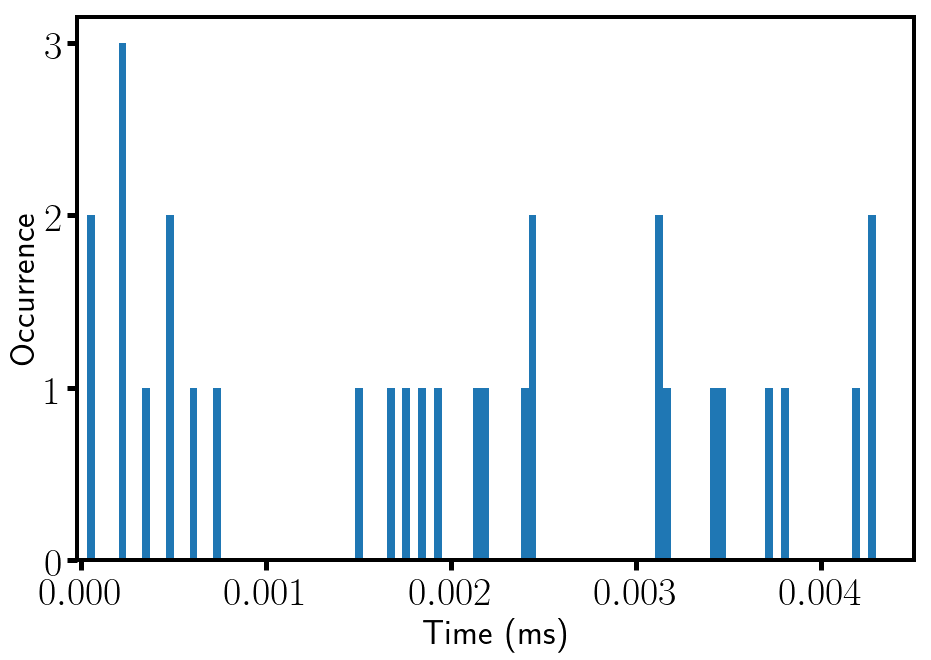

In [278]:
# python 2 & 3 compatible
from __future__ import print_function
import matplotlib as mpl
# For plotting & config
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *

# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection
td = 4.5e-3 # detection window
Rb = lam_b/td # photons/sec
N_sub = 100 # P(n>1) = 0.05
lam_sub = lam_b/N_sub
ti = td/N_sub # sub bin time

# Sample from Poisson for each sub bin
b_photons = np.random.poisson(lam_sub, int(N_sub))
# we can now look at bins with photons and assign them a random arival time

bright_time_tags = np.array([])
#iterate through each bin
for i in range(N_sub):
    # grab the number of photons per bin and  assign a random arival time
    for j in range(b_photons[i]):
        bright_time_tags = np.append(bright_time_tags, ti*(i) + np.random.random(1)*ti)

# check we're creating the correct number of photon time tags
print(np.sum(b_photons), len(bright_time_tags))
# check the times look right
print (bright_time_tags)        
    
bins = np.arange(0,N_sub,1)*ti
#print bins
#print b_photons
#bar(bins , b_photons , width = ti)
hist(bright_time_tags, bins = 100)
xlabel(r'Time (ms)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
xlim([-ti/2,4.5e-3])
show()

### Dark State

For an ion that starts in the dark state, spontaneous emission can cause decay to the bright state during the detection window.
For the case where the ion stays in the dark state during detection, the distribution of collected photons is Poissonian, with the mean ($\lambda_D$) given by the average detection rate ($R_D$) multiplied by the detection time ($t_D$):

$$\large P(n) = \frac{\lambda_D^n}{n!}e^{-\lambda_D}$$.

As before, we divide the detection window $t_D$ into $N_{bins}$ sub bins $t_i = \frac{t_D}{N_{bins}}$. The photon distribution in each sub bin will also follow a Poisson distribution with new mean given by $\lambda_{D_i} = R_Dt_i$.

$$\large P(n)_{D_i} = \frac{\lambda_{D_i}^n}{n!}e^{-\lambda_{D_i}}$$.

We follow the same prescription as the bright state to determine the number of photons per bin, and assign an arrival time to each.

To generate leakage events, we first need to determine the decay time $t_{\mathrm{decay}}$. The p.d.f. describing leakage from dark to bright is given by an exponential distribution:

$$\large f(t) = \frac{1}{\tau}e^{-t/\tau}$$

where $\tau \approx 31$s is the average leak time, and given by the lifetime of the dark state in our ion. To generate data with decays, we first sample from this distribution to determine detection attempts where a decay occurred. 
We then generate photon arrival times as previously described, where each sub bin with $t \leq t_{\mathrm{decay}}$ follows $P(n)_{D_i}$, and each sub bin with $t >  t_{\mathrm{decay}}$ follows $P(n)_{B_i}$. 

To simplify the math and coding, we assume the decay occurred at the end of the relevant sub bin, and sample from $P(n)_{D_i}$. As long as $t_i << t_D$ this assumption is valid.


Below we generate photon distributions for dark state detection with and without decays during detection.

### Dark State No Decay

1 1
[0.00428504]


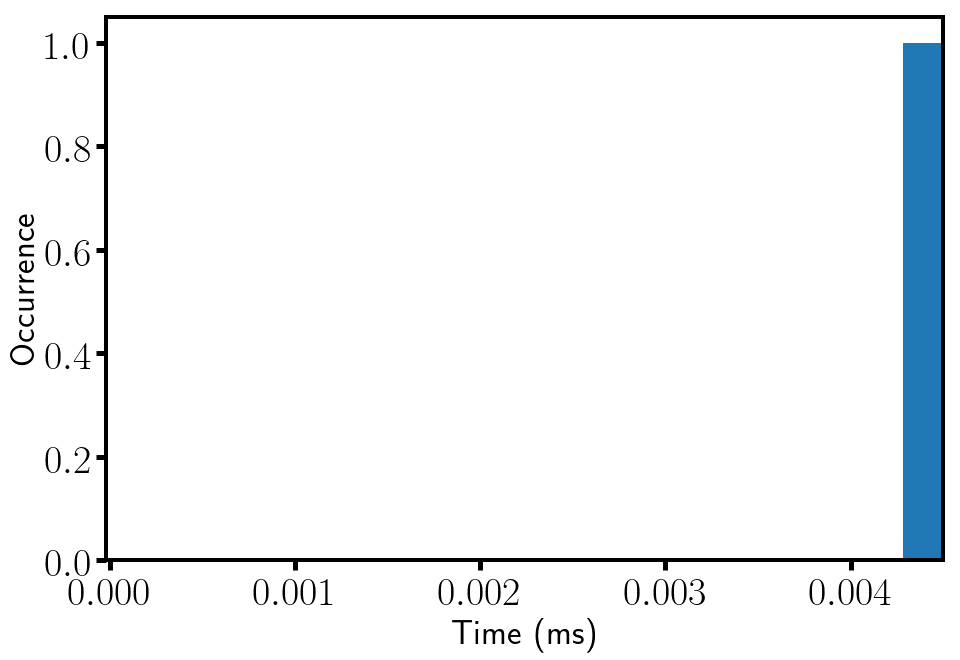

In [279]:
# python 2 & 3 compatible
from __future__ import print_function
# Dark state no decay
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *

# Definitions
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window
Rd = lam_d/td # photons/sec
N_sub = 100 # We choose N_sub to get one photon on average in each sub bin when bright
lam_sub_d = lam_d/N_sub
ti = td/N_sub # sub bin time

# Sample from Poisson for each sub bin
d_photons = np.random.poisson(lam_sub_d, int(N_sub))

# we can now look at bins with photons and assign them a random arival time
dark_time_tags = np.array([])
#iterate through each bin
for i in range(N_sub):
    # grab the number of photons per bin and  assign a random arival time
    for j in range(d_photons[i]):
        dark_time_tags = np.append(dark_time_tags, ti*(i) + np.random.random(1)*ti)

# check we're creating the correct number of photon time tags
print(np.sum(d_photons), len(dark_time_tags))
# check the times look right
print(dark_time_tags)  



#bins = np.arange(0,N_sub,1)*ti
#print bins
#print b_photons
#bar(bins , d_photons , width = ti)
hist(dark_time_tags, bins = 100)
xlabel(r'Time (ms)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
xlim([-ti/2,4.5e-3])
show()

### Dark State With Decay

First let's check Python's exponential sampling function and make sure it trends to the correct time constant.

Fitted value of time constatn:  31.1 s


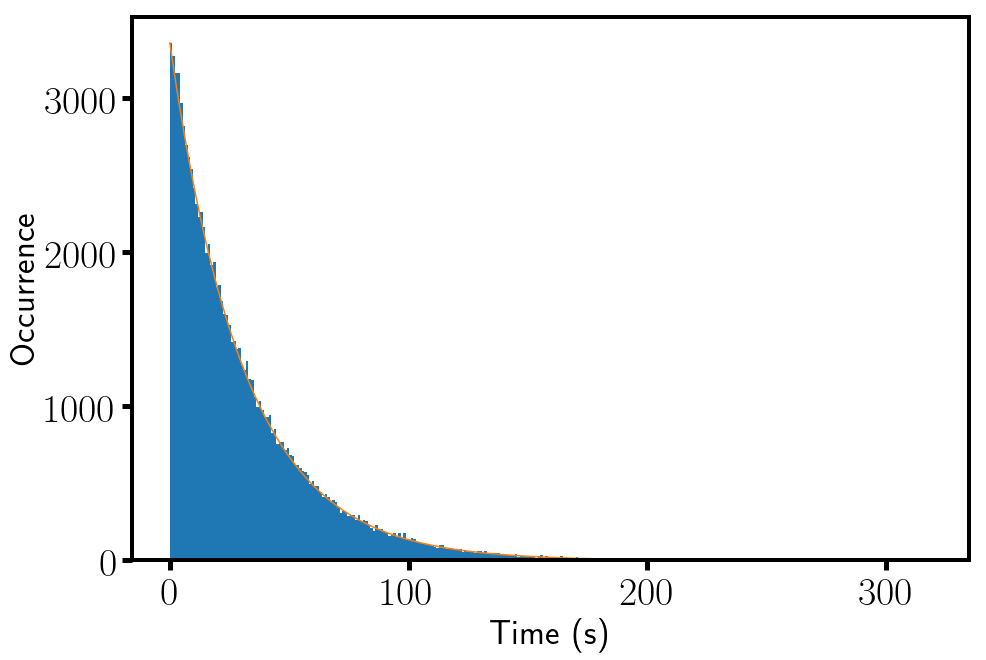

In [281]:
# python 2 & 3 compatible
from __future__ import print_function
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *
from scipy.optimize import curve_fit

### Sample from exponential distribution
tau = 31.0 # dark state lifetime
N = int(1e5) # sampling events
# Generate data
data = np.random.exponential(tau, N)

# Another way to sample from an exponential distribution
#data = -31*np.log(np.random.random(N))

# max bin value
m = np.amax(data)
# number of bins in histogram
n_bins = int(300)

#plot hist
h = hist(data, bins = n_bins, range = (0,m), align = 'mid')

# define function to fit sampled data to
def decay(t, tau, A):
    return A*np.exp(-t/tau)/tau

# fit sampled data
fit, err = curve_fit(decay, h[1][:-1], h[0], p0 = [31., N])

# plot sampled data over hist
y_fit = decay(h[1],fit[0], fit[1])
plot(h[1], y_fit)

# print fitted time constant
print('Fitted value of time constatn: ',  '{:.1f}'.format(fit[0]) + ' s')

xlabel(r'Time (s)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
show()

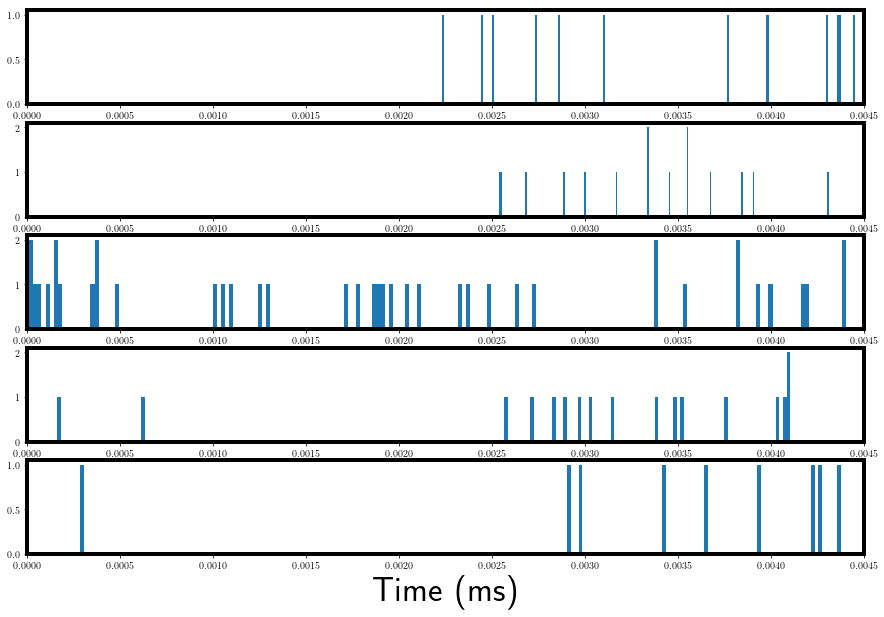

In [162]:
# python 2 & 3 compatible
from __future__ import print_function
### events with decay
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *


# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window
N_sub = 1000. # We choose N_sub to get one photon on average in each sub bin when bright
lam_sub_d = lam_d/N_sub # dark sub bin mean
lam_sub_b = lam_b/N_sub # bright sub bin mean
ti = td/N_sub # sub bin time
tau = 31.0 # dark state lifetime
N = int(1e5) # sampling events

# Generate data
data = np.random.exponential(tau, N)

# find events during the detection window
event_ind = np.where(data < td)
decay_events = data[event_ind[0]]

# determine which sub bin each event occurred in
decay_bin = floor(decay_events/ti) + 1
# Each element in decay bin is the number of dark state bins in each trial we need to sample from
# sum of the array decay_bin is the total number of dark state bins we need to sample
dark_bin_counts = np.random.poisson(lam_sub_d, int(np.sum(decay_bin)))

bright_bins = N_sub - decay_bin 
# (N_sub - decay_bin ) is an array of the number of bright bins in each decay event we need to sample
# the the sum of (N_sub-decay_bin) is the total numbe of bright bins we need to sample
bright_bin_counts = np.random.poisson(lam_sub_b, int(np.sum(bright_bins)))

# Now we just need to extract and concatenate the two photon distributions for each event
# I need to create an array which gives the starting postion of each new data set for the
# sampled distributions
count_ind_b = np.zeros(len(decay_bin))
count_ind_d = np.zeros(len(decay_bin))
for i in range(len(decay_bin)):
    count_ind_d[i] = np.sum(decay_bin[:i+1])
    count_ind_b[i] = np.sum(bright_bins[:i+1])

# now we use split to grab the distributions for each
d_counts = np.split(dark_bin_counts, count_ind_d.astype(int))
b_counts = np.split(bright_bin_counts, count_ind_b.astype(int))

# Now assign times and stich each bright and dark set together. 
# create an array to hold each trial
dark_tags_by_trial = []
for i in range((len(decay_events))):
    # creat array to store current trial tags
    dark_time_tags = np.array([])
    # do the dark counts
    for j in range(len(d_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(d_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)
    # do the bright counts
    for j in range(len(b_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(b_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j+ decay_bin[i]) + np.random.random(1)*ti)    
        
    dark_tags_by_trial.append(dark_time_tags)
    # check that we added the correct number of tags
    #print np.sum(d_counts[i]) + np.sum(b_counts[i]), len(dark_time_tags)

#all_tags = np.concatenate(dark_tags_by_trial).ravel()
#print all_tags
#hist(all_tags, bins = 100)

# lets plot the first 5
for i in range(5):
    subplot(5,1,i+1)
    hist(dark_tags_by_trial[i] , bins = 200)
    xlim([0,4.5e-3])
xlabel(r'Time (ms)', fontsize = 35)
#ylabel(r'Occurrence', fontsize = 35)
#tick_params(labelsize = 20)
#tick_params(width=5, length=10)    
show()


### Preparation Errors

Additional errors can occur during the preparation of either qubit state. In this case, an attempt to prepare the dark state is instead prepared bright, and an attempt to prepare bright is prepared dark. Experimental measurements allow us to determine the fraction of preparation errors for each state. To include these in our data, we sample from a Poisson distribution given by:

$$\large P(n)_{\mathrm{err}} = \frac{\lambda_{\mathrm{err}}^n}{n!}e^{-\lambda_{\mathrm{err}}}$$.

where the mean number of preparation errors for a given qubit state $\lambda_{\mathrm{err}}$ is given by the number of trials multiplied by the preparation error fraction. We then replace the sampled number of trials of the given qubit state with trials from the other qubit state.

# Generate New MC Data Set

The top of the cell contains parameters that can be changed. To generate a new data set, change the values accordingly and run the cell. There will be approximately 10 decay events for every 100,000 dark state trials.

In [25]:
# python 2 & 3 compatible
from __future__ import print_function
# Change parameters of the data set here
###################################
N_bright = int(1e6) # number of detection trials for each qubit state
N_dark = int(1e6)

# if you want to just generate extra leak events, set bool to true
extra_leak_events = True
# set the number of extra events you want
N_decay = int(1e3)

N_sub = 100 # number of sub bins. We choose N_sub to get one photon on average in each sub bin when bright

# include preparation errors
include_prep_error = False
bright_prep_error_frac = 2.e-4
dark_prep_error_frac = 2.5e-4

# save the data, must have .csv extension in file name
save_bright = False
save_dark_no_decay = False
save_dark_with_decay = False

bright_tags_file_name = 'bright_tags_by_trial_MC.csv'
dark_tags_no_decay_file_name = 'dark_tags_by_trial_no_decay_MC.csv'
dark_tags_with_decay_file_name =  'dark_tags_by_trial_with_decay_MC.csv'
dark_prep_errors_file_name =  'dark_prep_error_rows_MC.csv'
bright_prep_errors_file_name =  'bright_prep_error_rows_MC.csv'

###################################
# For plotting & config
rcParams['axes.linewidth'] = 4
rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *

# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection when in bright state
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window

lam_sub_d = lam_d/N_sub # dark sub bin mean
lam_sub_b = lam_b/N_sub # bright sub bin mean
ti = td/N_sub # sub bin time
tau = 31.0 # dark state lifetime
#N = int(N) # sampling events


####################################
# first generate bright state data
# Sample from Poisson for each sub bin when bright
bright_state_trials = np.reshape(np.random.poisson(lam_sub_b, int(N_sub*N_bright)),(N_bright,int(N_sub)))
# That was easy...
# Now add tags
bright_tags_by_trial = []
#iterate through each trial
for i in range(N_bright):
    # grab the number of photons per bin and  assign a random arival time
    # array to hold tags by trial
    bright_time_tags = np.array([])
    for j in range(N_sub):
        for k in range(bright_state_trials[i][j]):
            bright_time_tags = np.append(bright_time_tags, ti*(j) + np.random.random(1)*ti)

    bright_tags_by_trial.append(bright_time_tags)  

# should we include preparation errors?
if include_prep_error == True: 
    # sample from a Poisson do determine number of prep errors
    n_bright_prep_errors = np.random.poisson(N_bright*bright_prep_error_frac)
    # grab n random incides for replacing bright tags
    ind_b = np.random.random(n_bright_prep_errors)*N_bright
    ind_b = ind_b.astype(int)
    # replace bright state data with dark state data
    dark_state_trials_prep_error = np.reshape(np.random.poisson(lam_sub_d,int(N_sub*n_bright_prep_errors)), \
                                (n_bright_prep_errors,int(N_sub)))
    for i in range(n_bright_prep_errors):
        # replace bright state trials as well. Will speed up plotting below
        bright_state_trials[ind_b[i]] = dark_state_trials_prep_error[i]
        dark_time_tags = np.array([])
        # grab the number of photons per bin and  assign a random arival time
        for j in range(N_sub):
            for k in range(dark_state_trials_prep_error[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)
        bright_tags_by_trial[ind_b[i]] = dark_time_tags

if save_bright == True:
    import csv
    with open(bright_tags_file_name,'wb') as myfile:
      wr = csv.writer(myfile)
      wr.writerows(bright_tags_by_trial)

# save row numbers of bright prep errors        
if save_bright == True and include_prep_error == True:
      np.savetxt(bright_prep_errors_file_name, ind_b+1,delimiter = ',', fmt = '%10.0d')
        

####################################
# now the dark state without decay

# Generate decay data
data = np.random.exponential(tau, N_dark)

# find events during the detection window
event_ind = np.where(data < td)
decay_events = data[event_ind[0]]
# create new array of events without decay
no_decay_events = np.delete(data, event_ind[0])

# do no decays first
dark_state_trials_no_decay = np.reshape(np.random.poisson(lam_sub_d, int(N_sub*len(no_decay_events))),(len(no_decay_events),int(N_sub)))

dark_tags_by_trial_no_decay = []
#iterate through each trial
for i in range(len(no_decay_events)):
    # grab the number of photons per bin and  assign a random arival time
    # array to hold tags by trial
    dark_time_tags = np.array([])
    for j in range(N_sub):
        for k in range(dark_state_trials_no_decay[i][j]):
            dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)

    dark_tags_by_trial_no_decay.append(dark_time_tags)                                        

if include_prep_error == True:  
    # The probability of a prep error and a leakage error occurring together is ~ 10^-8,
    # so we only need to replace in the no decay events
    n_dark_prep_errors = np.random.poisson(N_dark*dark_prep_error_frac)
    # grab n random incides for replacing bright tags
    ind_d = np.random.random(n_dark_prep_errors)*len(no_decay_events)
    ind_d = ind_d.astype(int)
    # replace dark state data with bright state data
    bright_state_trials_prep_error = np.reshape(np.random.poisson(lam_sub_b,int(N_sub*n_dark_prep_errors)), \
                                (n_dark_prep_errors,int(N_sub)))
    for i in range(n_dark_prep_errors):
        # replace bright state trials as well. Will speed up plotting below
        dark_state_trials_no_decay[ind_d[i]] = bright_state_trials_prep_error[i]
        # grab the number of photons per bin and  assign a random arival time
        bright_time_tags = np.array([])
        for j in range(N_sub):
            for k in range(bright_state_trials_prep_error[i][j]):
                bright_time_tags = np.append(bright_time_tags, ti*(j) + np.random.random(1)*ti)
        dark_tags_by_trial_no_decay[ind_d[i]] = bright_time_tags

if save_dark_no_decay == True:
    import csv
    with open(dark_tags_no_decay_file_name,'wb') as myfile:
      wr = csv.writer(myfile) 
      wr.writerows(dark_tags_by_trial_no_decay)        
    
# save the row numbers for dark prep errors       
if save_dark_no_decay == True and include_prep_error == True:
      np.savetxt(dark_prep_errors_file_name, ind_d+1,delimiter = ',', fmt = '%10.0d')
        
######################################
# dark state with decays
# check and see if we want to add more decay errors
if extra_leak_events == True:
    # we'll sample 1e5 trials at a time until we get to the number we want
    while True:
        data = np.random.exponential(tau, int(1e6))
        event_ind = np.where(data < td)
        decay_events = np.append(decay_events,data[event_ind[0]])
        if len(decay_events) > N_decay:
            break
    # Cut off any extra data
    decay_events = decay_events[:N_decay]
    
# determine which sub bin each event occurred in
decay_bin = floor(decay_events/ti)
# Each element in decay bin is the number of dark state bins in each trial we need to sample from
# sum of the array decay_bin is the total number of dark state bins we need to sample
dark_bin_counts = np.random.poisson(lam_sub_d, int(np.sum(decay_bin)))

bright_bins = N_sub - decay_bin 
# (N_sub - decay_bin ) is an array of the number of bright bins in each decay event we need to sample
# the the sum of (N_sub-decay_bin) is the total numbe of bright bins we need to sample
bright_bin_counts = np.random.poisson(lam_sub_b, int(np.sum(bright_bins)))

# Now we just need to extract and concatenate the two photon distributions for each event
# I need to create an array which gives the starting postion of each new data set for the
# sampled distributions
count_ind_b = np.zeros(len(decay_bin))
count_ind_d = np.zeros(len(decay_bin))
for i in range(len(decay_bin)):
    count_ind_d[i] = np.sum(decay_bin[:i+1])
    count_ind_b[i] = np.sum(bright_bins[:i+1])

# now we use split to grab the distributions for each
d_counts = np.split(dark_bin_counts, count_ind_d.astype(int))
b_counts = np.split(bright_bin_counts, count_ind_b.astype(int))

# Now assign times and stich each bright and dark set together. 
# create an array to hold each trial
dark_tags_by_trial_decay = []
for i in range((len(decay_events))):
    # creat array to store current trial tags
    dark_time_tags = np.array([])
    # do the dark counts
    for j in range(len(d_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(d_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)
    # do the bright counts
    for j in range(len(b_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(b_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j+ decay_bin[i]) + np.random.random(1)*ti)    
        
    dark_tags_by_trial_decay.append(dark_time_tags)

print(len(dark_tags_by_trial_decay))

if save_dark_with_decay == True:
    import csv
    with open(dark_tags_with_decay_file_name,'wb') as myfile:
      wr = csv.writer(myfile) 
      wr.writerows(dark_tags_by_trial_decay)


1000


## Plot the above data to make sure it looks right

### Bright State

Bright Fit Poisson Mean:  39.58


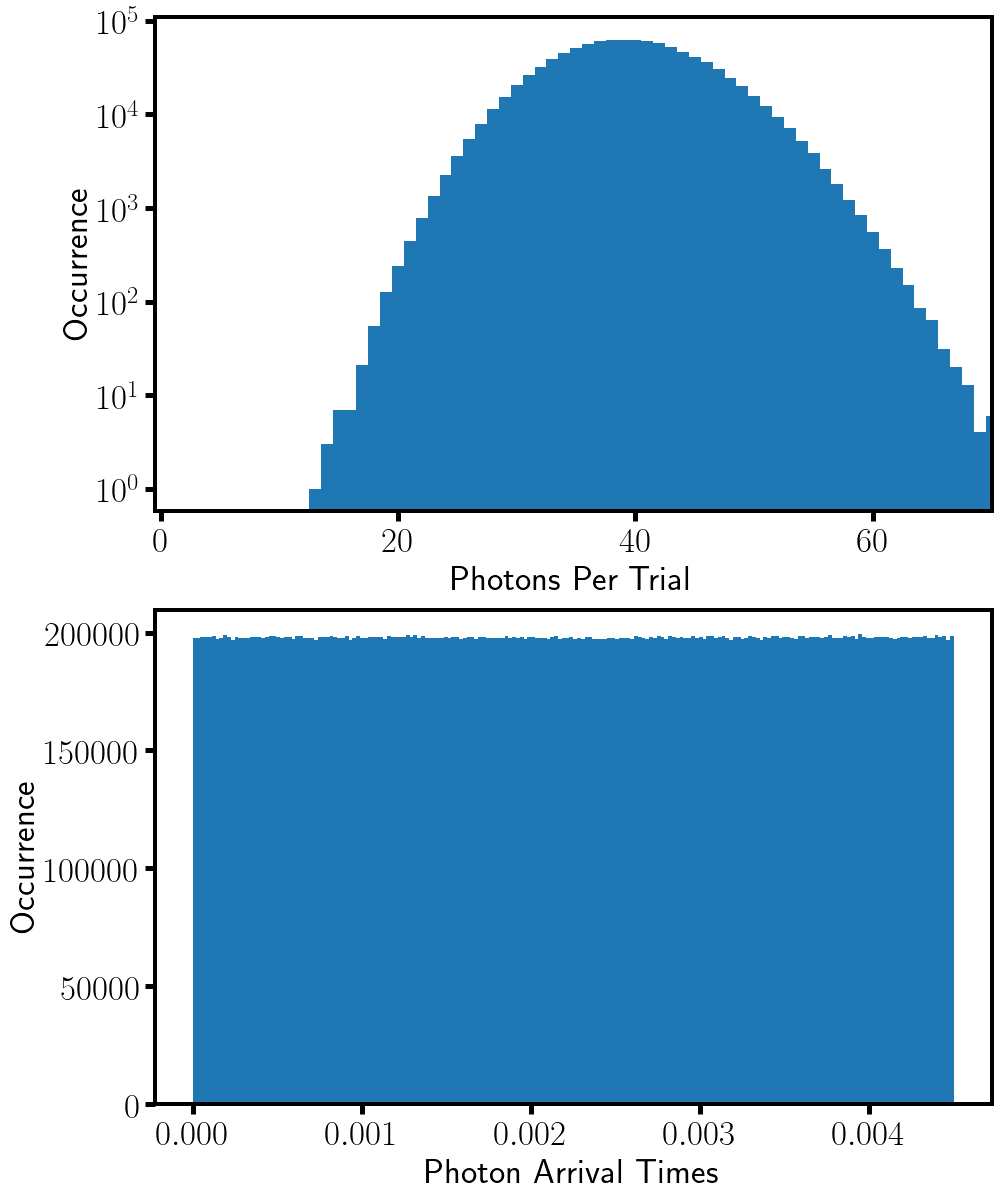

In [28]:
# python 2 & 3 compatible
from __future__ import print_function
### Bright state
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 20
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy.special import factorial

def poiss(x, mu):
        return (np.exp(-mu)*mu**x)/factorial(x)
    
# make a histogram of the total number of collected photons in each trial
# make list of total photons per trial
total_bright_counts_by_trial = np.sum(bright_state_trials, axis = 1)


subplot(2,1,1)
bright_hist = hist(total_bright_counts_by_trial.astype('float'), bins = np.arange(0,np.amax(total_bright_counts_by_trial)+1,1) ,align = 'left', log=True)

# grab the x-y data to fit a Lorentzian
x_bright = bright_hist[1][:-1]  
y_bright = bright_hist[0]/N_bright # normalize for the fit

fit_bright_p, bright_err_p = curve_fit(poiss,x_bright, y_bright, p0 = [39.])
print('Bright Fit Poisson Mean: ', '{:.2f}'.format(fit_bright_p[0]))
x_fit_bright = np.linspace(0,np.amax(total_bright_counts_by_trial.flatten()),1000)
y_fit_bright = poiss(x_fit_bright, fit_bright_p[0])*N_bright
#plot(x_fit_bright,y_fit_bright,'r', linewidth = 3)
xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)
xlim([-.5,70])

subplot(2,1,2)
# plot the photon arrival times
all_b_tags = np.concatenate(bright_tags_by_trial).ravel()
hist(all_b_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)
show()


### Dark State No Decay

Dark Fit Poisson Mean:  1.60


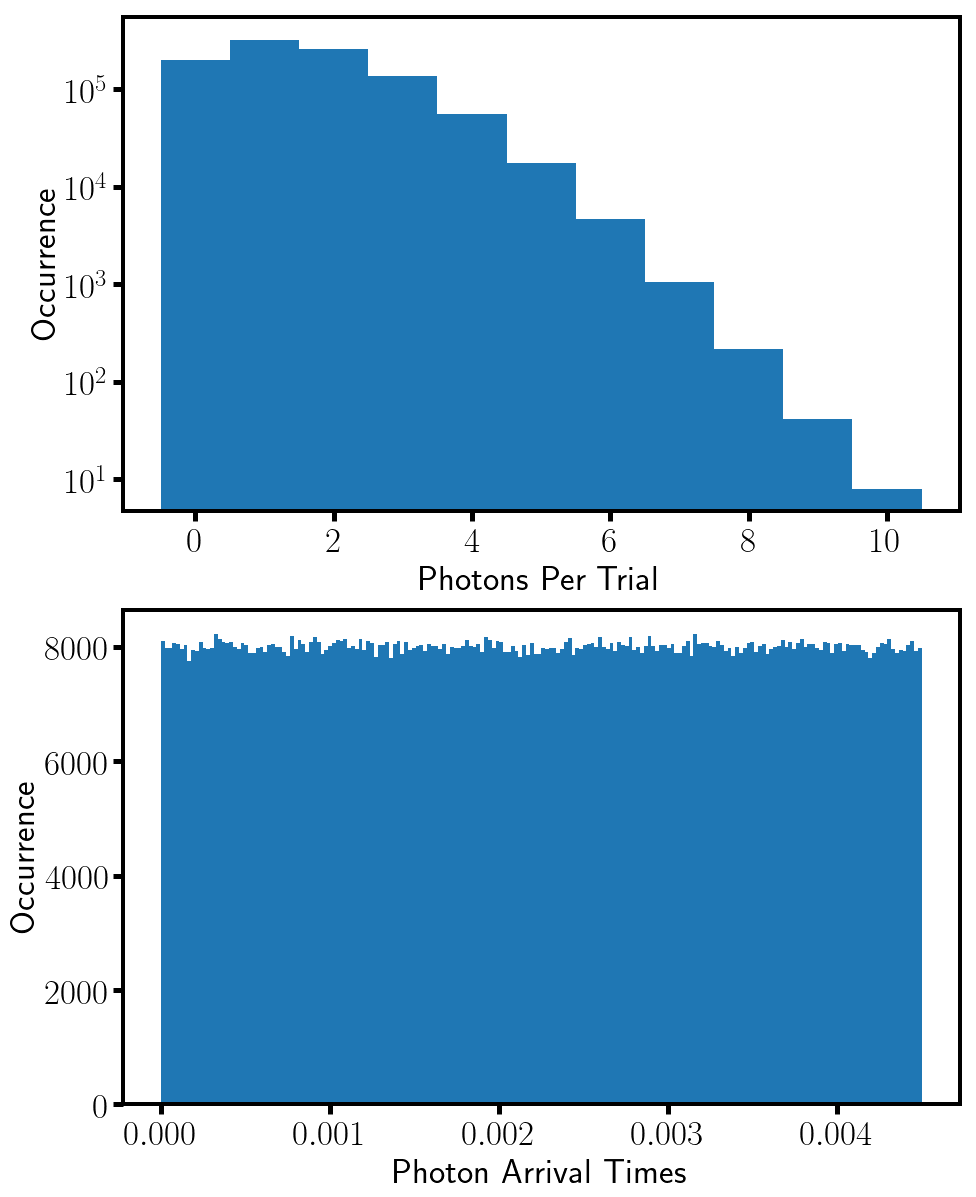

In [30]:
# python 2 & 3 compatible
from __future__ import print_function
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 20
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy.special import factorial

def poiss(x, mu):
        return (np.exp(-mu)*mu**x)/factorial(x)

    
    
# make list of total photons per trial
total_dark_counts_by_trial_no_decay = np.sum(dark_state_trials_no_decay, axis = 1)
    
    
subplot(2,1,1)
dark_hist = hist(total_dark_counts_by_trial_no_decay.flatten(), \
                 bins = np.arange(0,np.amax(total_dark_counts_by_trial_no_decay)+1,1), align = 'left', log=True)

# grab x-y data for Lorentzian fit
x_dark = dark_hist[1][:-1]  
y_dark = dark_hist[0]/len(no_decay_events) # normalize for the fit

fit_dark_p, dark_err_p = curve_fit(poiss,x_dark, y_dark, p0 = [1.6])
print('Dark Fit Poisson Mean: ', '{:.2f}'.format(fit_dark_p[0]))
x_fit_dark = np.linspace(0,20,1000)
y_fit_dark = poiss(x_fit_dark, fit_dark_p[0])*len(no_decay_events)

#plot(x_fit_dark,y_fit_dark,'r', linewidth = 3)
xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

# plot photon arrival times
subplot(2,1,2)
all_tags = np.concatenate(dark_tags_by_trial_no_decay).ravel()
hist(all_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

show()

### Dark State With Decay

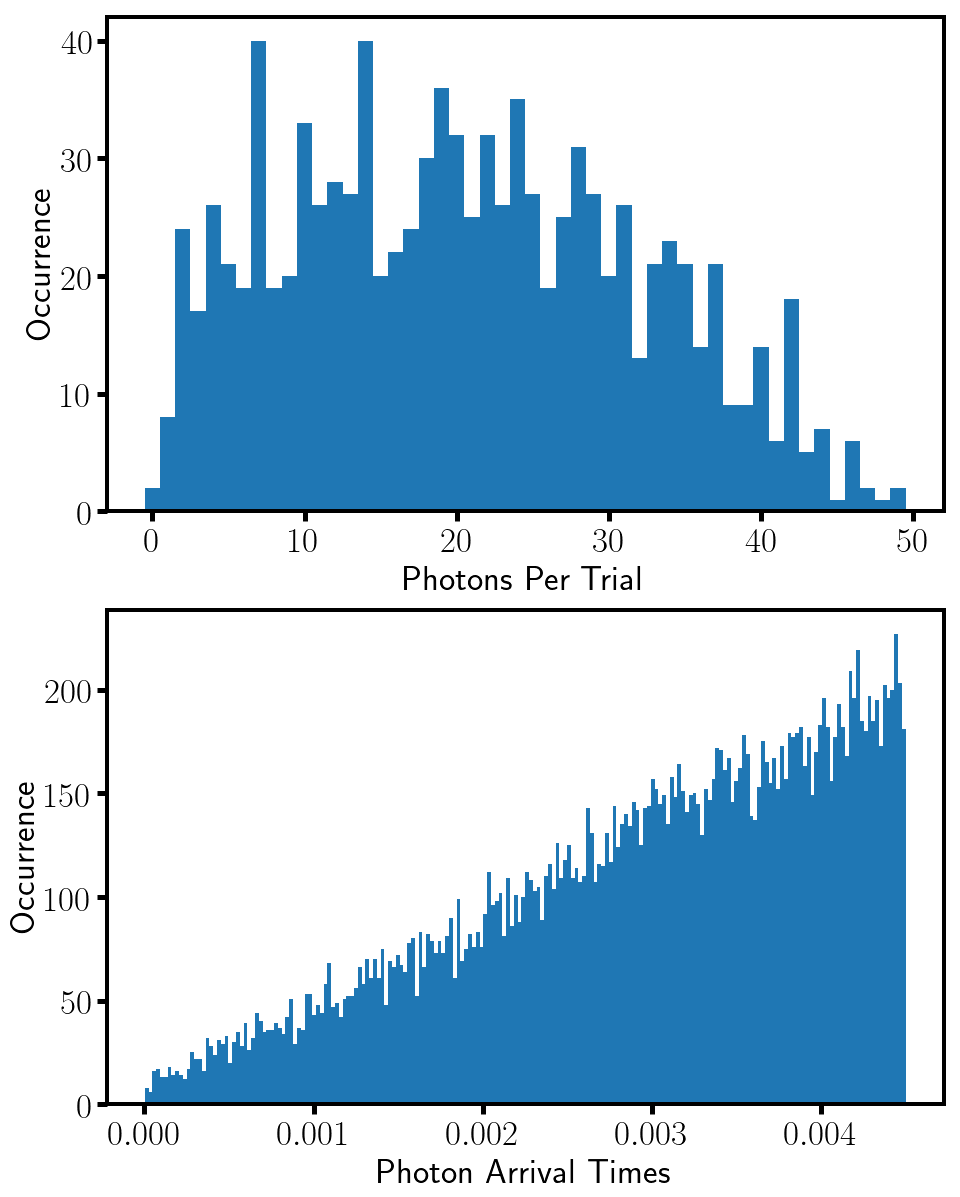

In [31]:
# python 2 & 3 compatible
from __future__ import print_function
### Decay events    
# For plotting & config
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams["figure.figsize"] = 15, 20
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy.special import factorial

# make a histogram of the total number of collected photons in each trial

# make list of total photons per trial
total_dark_counts_by_trial_decay = np.array([])
for i in range(len(dark_tags_by_trial_decay)):
    total_dark_counts_by_trial_decay = np.append(total_dark_counts_by_trial_decay, len(dark_tags_by_trial_decay[i]))

all_tags = np.concatenate(dark_tags_by_trial_decay).ravel()
subplot(2,1,1)
dark_hist = hist(total_dark_counts_by_trial_decay,bins = np.arange(0,np.amax(total_dark_counts_by_trial_decay)+1,1), align = 'left')


xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

# plot photon arrival times
subplot(2,1,2)
all_tags = np.concatenate(dark_tags_by_trial_decay).ravel()
hist(all_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)


### Total Dark State

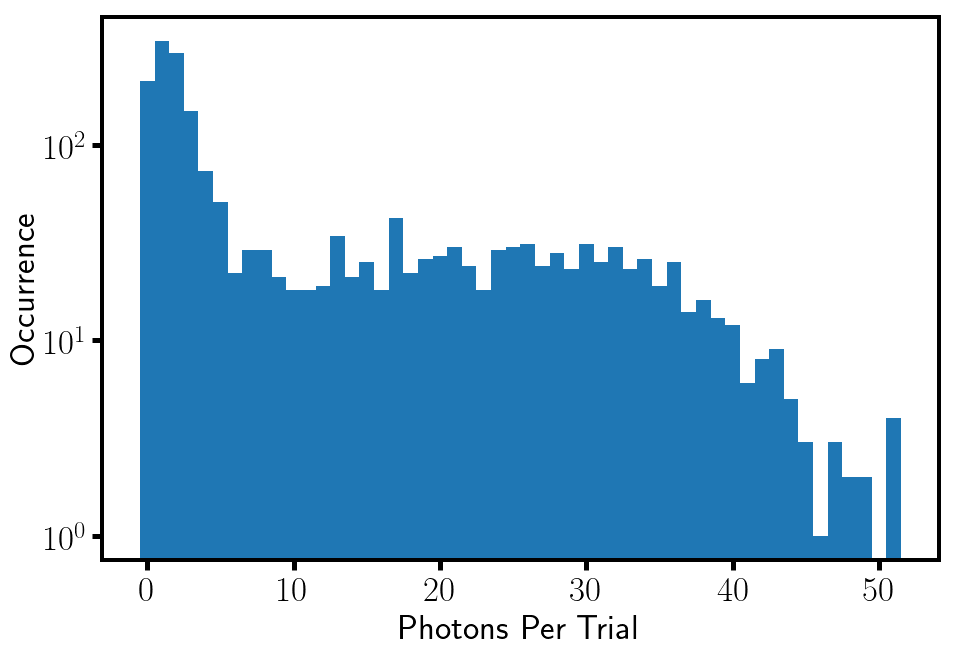

In [23]:
from __future__ import print_function
### Plot the total dark state on a log scale
# For plotting & config
rcParams['axes.linewidth'] = 4
rcParams["figure.figsize"] = 15, 10
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy.special import factorial

total_dark = np.concatenate((total_dark_counts_by_trial_no_decay,total_dark_counts_by_trial_decay))
dark_hist = hist(total_dark,bins = np.arange(0,np.amax(total_dark)+1,1), align = 'left', log='True')

xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)
show()

In [45]:
# get the fidelity
# will be wrong if you include extra leak events

th = np.arange(13,15,1)

for disc in th:
    print('discriminator: ', disc)
    err_d = len(np.where(total_dark > disc)[0])
    print('Num dark errors: ', err_d)
    print('fractional dark error :', '{:.5e}'.format(1- float(err_d)/N_dark))
    

    err_b = len(np.where(total_bright_counts_by_trial <= disc)[0])
    print('Num bright errors: ', err_b)
    print('fractional bright error :', '{:.5e}'.format(1- float(err_b)/N_bright))
    
    print('Average error :', '{:.5e}'.format(1-.5*(float(err_d)/N_dark+ float(err_b)/N_bright)) + '\n')

discriminator:  13
Num dark errors:  695
fractional dark error : 9.99305e-01
Num bright errors:  1
fractional bright error : 9.99999e-01
Average error : 9.99652e-01

discriminator:  14
Num dark errors:  674
fractional dark error : 9.99326e-01
Num bright errors:  4
fractional bright error : 9.99996e-01
Average error : 9.99661e-01

